In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from utils.station_network import StationNetworkSimul
import networkx as nx
from pyvis.network import Network
import random
from gnn_model import StationFlowGNN, InterStationFlowGNN
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch
import torch.optim as optim
from tqdm import tqdm

In [147]:
df_stations = pd.read_csv('data/pau_challenge/plan du métro.csv')
df_stations = df_stations[~df_stations['vers Ligne'].isin(['\xa01', '\xa07', '\xa02', '\xa08', '\xa06'])]

df_pos = pd.read_csv("data/pau_challenge/position gps des stations de métro.csv")

#Removing Malsesherbes RER Station
df_pos = df_pos.drop([151])

df_flow = pd.read_csv('data/pau_challenge/passagers.csv')
df_flow['nombre'] = df_flow['nombre'].astype(float)

In [52]:
path_flows = df_flow[['de', 'vers', 'nombre']].to_dict('records')

In [37]:
path_flows

[{'de': 'La Défense', 'vers': 'Esplanade de La Défense', 'nombre': 7.0},
 {'de': 'La Défense', 'vers': 'Pont de Neuilly', 'nombre': 5.0},
 {'de': 'La Défense', 'vers': 'Les Sablons', 'nombre': 6.0},
 {'de': 'La Défense', 'vers': 'Porte Maillot', 'nombre': 6.0},
 {'de': 'La Défense', 'vers': 'Argentine', 'nombre': 5.0},
 {'de': 'La Défense', 'vers': 'Charles de Gaulle - Étoile', 'nombre': 7.0},
 {'de': 'La Défense', 'vers': 'George V', 'nombre': 5.0},
 {'de': 'La Défense', 'vers': 'Franklin D. Roosevelt', 'nombre': 1.0},
 {'de': 'La Défense', 'vers': 'Champs-Élysées - Clemenceau', 'nombre': 2.0},
 {'de': 'La Défense', 'vers': 'Concorde', 'nombre': 8.0},
 {'de': 'La Défense', 'vers': 'Tuileries', 'nombre': 1.0},
 {'de': 'La Défense', 'vers': 'Palais-Royal - Musée du Louvre', 'nombre': 2.0},
 {'de': 'La Défense', 'vers': 'Louvre - Rivoli', 'nombre': 1.0},
 {'de': 'La Défense', 'vers': 'Châtelet', 'nombre': 7.0},
 {'de': 'La Défense', 'vers': 'Hôtel de Ville', 'nombre': 5.0},
 {'de': 'La D

In [150]:
test_network = StationNetworkSimul(df_stations=df_stations, df_pos=df_pos)

In [151]:
test_network.network_graph.nodes[0]

{'title': 'Abbesses',
 'group': '12',
 'x': 2.3379497756920697,
 'y': 48.884594208027806}

In [104]:
from copy import deepcopy

In [160]:
def create_pyvis_from_nx(nx_graph : nx.DiGraph, scaling_factor=10000):
    net = Network(directed=True)
    
    for node_idx, node_data in nx_graph.nodes.items():
        new_data = deepcopy(node_data)
        new_data['x']*=scaling_factor
        new_data['y']*=-scaling_factor
        net.add_node(
            node_idx, 
            size=new_data['traffic']/1000, 
            group = new_data['group'],
            title = f"{new_data['title']} (Ligne {new_data['group']})\nTraffic: {new_data['traffic']}",
            x = new_data['x'],
            y = new_data['y'],)
    
    for edge in nx_graph.edges:
        net.add_edge(*edge)
    
    net.toggle_physics(False)
    return net

In [110]:
pyvis_test = Network(directed=True, height="500px", width="800px")

pyvis_test.add_node(0, x=0., y=0.)
pyvis_test.add_node(1, x=1., y=0.)
pyvis_test.add_node(2, x=0., y=100.)
pyvis_test.add_node(3, x=1., y=1.)

pyvis_test.toggle_physics(False)

pyvis_test.save_graph('viz/test_pos.html')

In [152]:
test_network.set_edges_weights()
test_network.set_nodes_traffic(path_flows=path_flows)
test_network.network_graph.nodes[0]

{'title': 'Abbesses',
 'group': '12',
 'x': 2.3379497756920697,
 'y': 48.884594208027806,
 'traffic': 11286.0}

In [161]:
# pyvis_net = Network(directed=True)
# pyvis_net.from_nx(test_network.network_graph)
pyvis_net = create_pyvis_from_nx(test_network.network_graph, 50000)
pyvis_net.save_graph('viz/network_graph_fixed_pos.html')

In [65]:
test_network.set_edges_traffic(df_flow=df_flow)

In [ ]:
new_net, removed_edges = test_network.get_degraded_network()
removed_edges

[(155, 154),
 (85, 86),
 (227, 230),
 (248, 312),
 (290, 123),
 (339, 338),
 (248, 249),
 (76, 73),
 (77, 76),
 (327, 328)]

#### Node model

In [59]:
num_degraded = 1000
degraded_graphs = []
for i in tqdm(range(num_degraded), total=num_degraded):
    new_net, removed_edges = test_network.get_degraded_network(num_delete=10)
    test_network.update_degraded_network_nodes_traffic(new_net, removed_edges, df_flow)
    tensor_positions = torch.tensor([[node['lon'], node['lat']] for _, node in sorted(new_net.nodes.data())], dtype=torch.float)
    tensor_edges = torch.tensor([
        [edge[0] for edge in new_net.edges],
        [edge[1] for edge in new_net.edges]
        ], dtype=torch.long)
    tensor_traffic = torch.tensor([node['traffic'] for _, node in new_net.nodes.data()], dtype=torch.float)
    total_traffic = sum(tensor_traffic)
    tensor_traffic /= total_traffic
    data_graph = Data(x=tensor_positions, edge_index=tensor_edges, y=tensor_traffic)
    degraded_graphs.append(data_graph)

  0%|          | 0/1000 [00:12<?, ?it/s]


KeyboardInterrupt: 

In [57]:
split_idx = int(0.1*num_degraded)
train_loader = DataLoader(degraded_graphs[split_idx:])
dev_loader = DataLoader(degraded_graphs[:split_idx])

In [65]:
input_dim = 2
output_dim = 1
hidden_dim = 16

nodes_gnn_model = StationFlowGNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

lr = 0.001
optimizer = optim.Adam(nodes_gnn_model.parameters(), lr=lr)
criterion = torch.nn.MSELoss()

epochs = 100

for epoch in range(epochs):
    nodes_gnn_model.train()
    train_loss = []
    for data in train_loader:
        nodes_gnn_model.train()
        optimizer.zero_grad()
        output = nodes_gnn_model(data)
        loss = criterion(output.squeeze(), data.y)
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    if epoch%10 == 0:
        dev_loss = []
        nodes_gnn_model.eval()
        for data in dev_loader:
            output = nodes_gnn_model(data)
            test = set(output.squeeze().tolist())
            print(max(test), min(test))
            loss = criterion(output.squeeze(), data.y)
            dev_loss.append(loss.item())
        print(f'Epoch {epoch}, Train Loss: {np.mean(train_loss)}, Dev. Loss: {np.mean(dev_loss)}')


0.062011945992708206 0.014190839603543282
0.05706111714243889 0.014674628153443336
0.05599277839064598 0.013470461592078209
0.05627765133976936 0.014674628153443336
0.06903938204050064 0.014256419613957405
0.07714901119470596 0.013532581739127636
0.05800146609544754 0.01452404074370861
0.055724963545799255 0.013827169314026833
0.074531190097332 0.014256032183766365
0.056184105575084686 0.014674628153443336
Epoch 0, Train Loss: 0.375003331459205, Dev. Loss: 0.0008895774779375642
0.02158559113740921 0.0025084323715418577
0.01909305527806282 0.002628050511702895
0.018564851954579353 0.0023222232703119516
0.01870647817850113 0.002628050511702895
0.025333577767014503 0.0025252371560782194
0.029932480305433273 0.0023424057289958
0.019549431279301643 0.0025938497856259346
0.018434496596455574 0.0024163038469851017
0.028432948514819145 0.0025251435581594706
0.018659086897969246 0.002628050511702895
Epoch 10, Train Loss: 4.568648623212034e-05, Dev. Loss: 4.1925537516362965e-05
0.014479261822998

In [74]:
test_degraded_network, removed_edges = test_network.get_degraded_network()

In [66]:
test_network.update_degraded_network_nodes_traffic(test_degraded_network, removed_edges, df_flow)

In [67]:
pos = {node_idx : (node['lon'], node['lat']) for node_idx, node in test_degraded_network.nodes.items()}

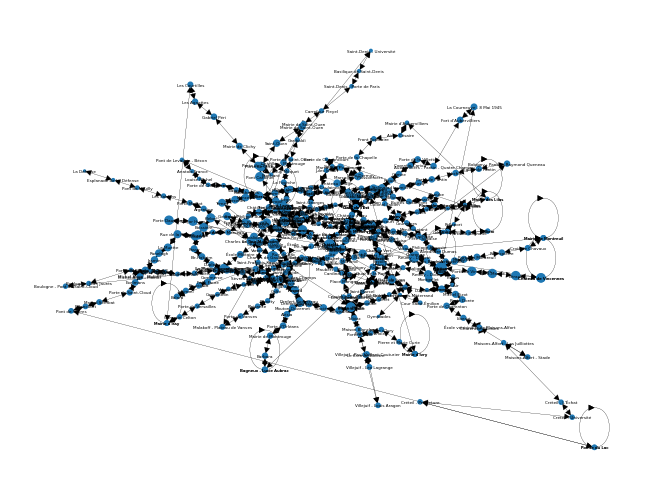

In [68]:
node_size = [5000*node['traffic']/total_traffic for node in test_degraded_network.nodes.values()]
nx.draw(test_degraded_network, node_size=node_size, width=0.1, pos=pos, labels=nx.get_node_attributes(test_degraded_network, 'title'), font_size=3)

In [69]:
tensor_positions = torch.tensor([[node['lon'], node['lat']] for _, node in sorted(test_degraded_network.nodes.data())], dtype=torch.float)
tensor_edges = torch.tensor([
    [edge[0] for edge in test_degraded_network.edges],
    [edge[1] for edge in test_degraded_network.edges]
    ], dtype=torch.long)
tensor_traffic = torch.tensor([node['traffic'] for _, node in new_net.nodes.data()], dtype=torch.float)
total_traffic = sum(tensor_traffic)
tensor_traffic /= total_traffic
data_graph = Data(x=tensor_positions, edge_index=tensor_edges, y=tensor_traffic)

In [70]:
print(max(tensor_traffic))

tensor(0.0114)


In [71]:
output = nodes_gnn_model(data_graph).squeeze()
output = output.detach().numpy()

In [72]:
max(output)

0.011023012

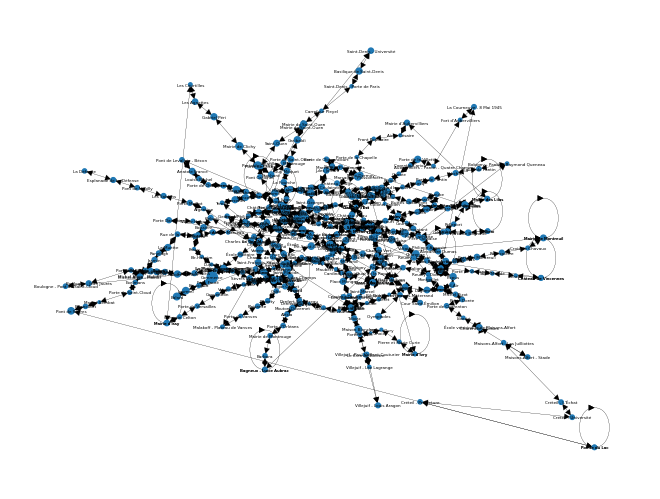

In [73]:
node_size = [5000*pred for pred in output]
nx.draw(test_degraded_network, node_size=node_size, width=0.1, pos=pos, labels=nx.get_node_attributes(test_degraded_network, 'title'), font_size=3)

#### Edge model

In [82]:
num_degraded = 100
degraded_graphs = []
for i in tqdm(range(num_degraded), total=num_degraded):
    new_net, removed_edges = test_network.get_degraded_network(num_delete=1)
    test_network.update_degraded_network_edges_traffic(new_net, removed_edges, df_flow)
    tensor_positions = torch.tensor([[node['lon'], node['lat']] for _, node in sorted(new_net.nodes.data())], dtype=torch.float)
    tensor_edges = torch.tensor([
        [edge[0] for edge in new_net.edges],
        [edge[1] for edge in new_net.edges]
        ], dtype=torch.long)
    tensor_traffic = torch.tensor([edge['traffic'] for _,_,  edge in new_net.edges.data()], dtype=torch.float)
    total_traffic = sum(tensor_traffic)
    tensor_traffic /= total_traffic
    data_graph = Data(x=tensor_positions, edge_index=tensor_edges, edge_attr=tensor_traffic)
    degraded_graphs.append(data_graph)

100%|██████████| 100/100 [09:03<00:00,  5.43s/it]


In [83]:
split_idx = int(0.1*num_degraded)
train_loader = DataLoader(degraded_graphs[split_idx:])
dev_loader = DataLoader(degraded_graphs[:split_idx])

In [89]:
input_dim = 2
output_dim = 1
hidden_dim = 16

edges_gnn_model = InterStationFlowGNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

lr = 0.01
optimizer = optim.Adam(edges_gnn_model.parameters(), lr=lr)
criterion = torch.nn.L1Loss()

epochs = 100

for epoch in range(epochs):
    edges_gnn_model.train()
    train_loss = []
    for data in train_loader:
        optimizer.zero_grad()
        output = edges_gnn_model(data).squeeze()
        target = data.edge_attr.squeeze()
        loss = criterion(output, target)
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    if epoch%10 == 0:
        dev_loss = []
        edges_gnn_model.eval()
        for data in dev_loader:
            output = edges_gnn_model(data).squeeze()
            print(set(output.tolist()))
            target = data.edge_attr.squeeze()
            loss = criterion(output, target)
            dev_loss.append(loss.item())
        print(f'Epoch {epoch}, Train Loss: {np.mean(train_loss)}, Dev. Loss: {np.mean(dev_loss)}')

{0.0030527710914611816, 0.002021089196205139, 0.002884224057197571, -0.00738370418548584, -0.009936362504959106, 0.0024458318948745728, -0.0070219486951828, -0.00699470192193985, 0.002115093171596527, 0.0027083829045295715, 0.006967872381210327, -0.009529538452625275, -0.003796398639678955, -0.013450391590595245, -0.007611006498336792, -0.004394732415676117, -0.009526394307613373, -0.006143711507320404, -0.009109549224376678, -0.0053887739777565, -0.002021700143814087, -0.013443134725093842, -0.0073548778891563416, -0.013446949422359467, -0.00503983348608017, -0.007826708257198334, 0.002141810953617096, -0.00526871532201767, 0.004694797098636627, -0.01642312854528427, 0.005403146147727966, -0.00761355459690094, -0.018243208527565002, 1.30385160446167e-06, -0.007307656109333038, -0.01634848862886429, -0.008513100445270538, -0.010805733501911163, -0.008810646831989288, -0.011580117046833038, -0.006956703960895538, -0.009693749248981476, -0.006567604839801788, -0.005962349474430084, -0.01

In [85]:
test_degraded_network, removed_edges = test_network.get_degraded_network()
test_network.update_degraded_network_edges_traffic(test_degraded_network, removed_edges, df_flow)
tensor_positions = torch.tensor([[node['lon'], node['lat']] for _, node in sorted(test_degraded_network.nodes.data())], dtype=torch.float)
tensor_edges = torch.tensor([
    [edge[0] for edge in test_degraded_network.edges],
    [edge[1] for edge in test_degraded_network.edges]
    ], dtype=torch.long)
tensor_traffic = torch.tensor([edge['traffic'] for _,_,  edge in test_degraded_network.edges.data()], dtype=torch.float)
total_traffic = sum(tensor_traffic)
tensor_traffic /= total_traffic
data_graph = Data(x=tensor_positions, edge_index=tensor_edges, edge_attr=tensor_traffic)


In [86]:
output = edges_gnn_model(data_graph).squeeze()
target = data_graph.edge_attr.squeeze()
loss = criterion(output, target)
print(loss.item())

0.0005763000226579607


In [88]:
print(set(output.tolist()))

{0.0009513646364212036}


#### Viz

In [30]:
test_removed_edge = random.choice(removed_edges)
print(test_removed_edge)

test_affected_paths = test_network.shortest_path_cache_reverse[test_removed_edge]
print(len(test_affected_paths))

test_affected_path_idx = random.choice(test_affected_paths)
print(test_affected_path_idx)

start_path = df_flow.iloc[test_affected_path_idx]['de']
end_path = df_flow.iloc[test_affected_path_idx]['vers']

current_best_path = test_network.get_best_path(test_network.network_graph, start_path, end_path)
degraded_best_path = test_network.get_best_path(new_net, start_path, end_path)



(311, 190)
5169
46992


In [27]:
for neighbor in test_network.network_graph.neighbors(267):
    print(test_network.network_graph.nodes[neighbor]['title'], test_network.network_graph.nodes[neighbor]['group'])

Place d'Italie 5
Place d'Italie 7
Corvisart 6
Charles de Gaulle - Étoile 6
Nationale 6


In [31]:
print("->\n".join([f'{n} - {test_network.reverse_network_stations[n]["title"]} ({test_network.reverse_network_stations[n]["group"]})' for n in current_best_path]))

373 - Sully - Morland (7)->
278 - Pont Marie (7)->
77 - Châtelet (7)->
75 - Châtelet (14)->
311 - Pyramides (14)->
190 - Madeleine (14)->
191 - Madeleine (8)->
86 - Concorde (8)->
149 - Invalides (8)->
170 - La Tour-Maubourg (8)->
399 - École Militaire (8)->
168 - La Motte-Picquet - Grenelle (8)->
83 - Commerce (8)->
119 - Félix Faure (8)->
40 - Boucicaut (8)->
186 - Lourmel (8)->
16 - Balard (8)


In [32]:
print("->\n".join([f'{n} - {test_network.reverse_network_stations[n]["title"]} ({test_network.reverse_network_stations[n]["group"]})' for n in degraded_best_path]))

373 - Sully - Morland (7)->
160 - Jussieu (7)->
265 - Place Monge (7)->
54 - Censier - Daubenton (7)->
178 - Les Gobelins (7)->
268 - Place d'Italie (7)->
380 - Tolbiac (7)->
205 - Maison Blanche (7)->
173 - Le Kremlin-Bicêtre (7)->
392 - Villejuif - Léo Lagrange (7)->
393 - Villejuif - Paul Vaillant-Couturier (7)->
391 - Villejuif - Louis Aragon (7)->
287 - Porte d'Italie (7)->
293 - Porte de Choisy (7)->
288 - Porte d'Ivry (7)->
262 - Pierre et Marie Curie (7)->
195 - Mairie d'Ivry (7)->
196 - Mairie d'Ivry (7bis)->
184 - Louis Blanc (7bis)->
155 - Jaurès (7bis)->
36 - Bolivar (7bis)->
46 - Buttes Chaumont (7bis)->
39 - Botzaris (7bis)->
99 - Danube (7bis)->
272 - Place des Fêtes (7bis)->
309 - Pré-Saint-Gervais (7bis)->
310 - Pré-Saint-Gervais (8)->
16 - Balard (8)


In [167]:
pos = {node_idx : (node['lon'], node['lat']) for node_idx, node in test_network.network_graph.nodes.items()}

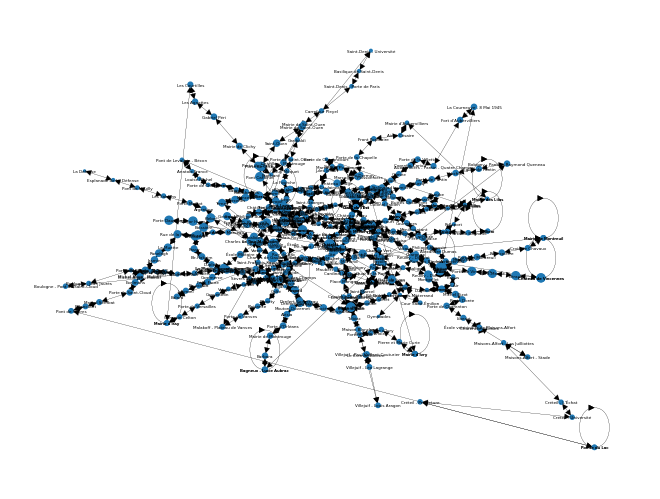

In [168]:

totat_traffic = sum(nx.get_node_attributes(test_network.network_graph, 'traffic').values())
node_size = [5000*node['traffic']/totat_traffic for node in test_network.network_graph.nodes.values()]
nx.draw(test_network.network_graph, node_size=node_size, width=0.1, pos=pos, labels=nx.get_node_attributes(test_network.network_graph, 'title'), font_size=3)

In [169]:
totat_traffic

7710100.0

In [170]:
sum(nx.get_node_attributes(new_net, 'traffic').values())

7715163.0

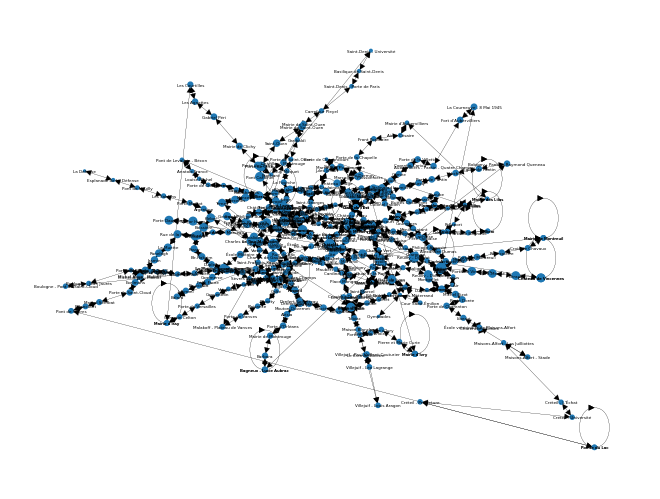

In [155]:

totat_traffic = sum(nx.get_node_attributes(test_network.network_graph, 'traffic').values())
node_size = [5000*node['traffic']/totat_traffic for node in new_net.nodes.values()]
nx.draw(new_net, node_size=node_size, width=0.1, pos=pos, labels=nx.get_node_attributes(new_net, 'title'), font_size=3)

In [159]:
test_network.network_graph.nodes[0]

{'title': 'Abbesses',
 'group': '12',
 'lon': 2.3379497756920697,
 'lat': 48.884594208027806,
 'traffic': 9622,
 'size': 10}

In [171]:
net_viz = Network(directed=True)
net_viz.from_nx(test_network.network_graph)
net_viz.save_graph('viz/network_graph_test.html')

In [172]:
net_viz = Network(directed=True)
net_viz.from_nx(new_net)
net_viz.save_graph('viz/network_graph_degraded.html')

In [31]:
len(test_network.network_graph.edges)

1054